In [32]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [33]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_styled_landmarks(image, results):
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [106]:
data_path = os.path.join('TrashData')
actions = np.array(['hello', 'thanks', 'eat', 'help', 'goodbye', 'no', 'yes', 'please', 'sorry', 'what'])
no_sequences = 30
sequence_length = 30

for action in actions:
    for sequence in range(1, no_sequences + 1):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except FileExistsError:
            pass

In [107]:
ls /dev/video*

/dev/video0  /dev/video1


In [108]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(1, no_sequences + 1):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)

                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/radeonsi_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/zink_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/swrast_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libs

In [3]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [4]:
no_sequences = 30
sequence_length = 30

data_path = 'TrashData'
actions = np.array(['hello', 'thanks', 'eat', 'help', 'goodbye', 'no', 'yes', 'please', 'sorry', 'what'])

In [5]:
label_map = {label: num for num, label in enumerate(actions)}
sequences, labels = [], []

for action in actions:
    for sequence in range(1, no_sequences + 1):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

sequences = np.array(sequences)
labels = np.array(labels)

print(f"Shape of sequences: {sequences.shape}")
print(f"Shape of labels: {labels.shape}")


Shape of sequences: (300, 30, 1662)
Shape of labels: (300,)


In [34]:
sequence_length = sequences.shape[1]  
keypoints_size = sequences.shape[2]   # 1662
print(keypoints_size)

1662


In [35]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=len(actions))
y_test = to_categorical(y_test, num_classes=len(actions))

In [36]:
X_train = X_train.reshape(-1, sequence_length, keypoints_size, 1)
X_test = X_test.reshape(-1, sequence_length, keypoints_size, 1)

print("Shape of:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

Shape of:
X_train: (240, 30, 1662, 1)
X_test: (60, 30, 1662, 1)
y_train: (240, 10)
y_test: (60, 10)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam

In [38]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [39]:
trashmodelo = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)),
    LSTM(128, return_sequences=True, activation='relu'),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # Dropout(0.5),
    Dense(actions.shape[0], activation='softmax')
    
])

In [40]:
trashmodelo.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history= trashmodelo.fit(X_train, y_train, epochs=100, callbacks=[tb_callback],
                         validation_data=(X_test, y_test))

Epoch 1/100


2024-06-15 22:22:05.583430: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47865600 exceeds 10% of free system memory.


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.0852 - loss: 3.6394 - val_accuracy: 0.1333 - val_loss: 2.3074
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0844 - loss: 2.3401 - val_accuracy: 0.1667 - val_loss: 2.3144
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0807 - loss: 2.3098 - val_accuracy: 0.1500 - val_loss: 2.3125
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0860 - loss: 2.3056 - val_accuracy: 0.0333 - val_loss: 2.3300
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0962 - loss: 2.3082 - val_accuracy: 0.0333 - val_loss: 2.3213
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1183 - loss: 2.3034 - val_accuracy: 0.0333 - val_loss: 2.3212
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1120 - loss: 2.3010 - val_accuracy: 0.0333 - val_loss: 2.3215
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1052 - loss: 2.2991 - val_accuracy: 0.0333 - val_loss: 2.3240
Epoc

## Model Summary

In [30]:
trashmodelo.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,720 (6.83 MB)

 Trainable params: 596,906 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,814 (4.55 MB)

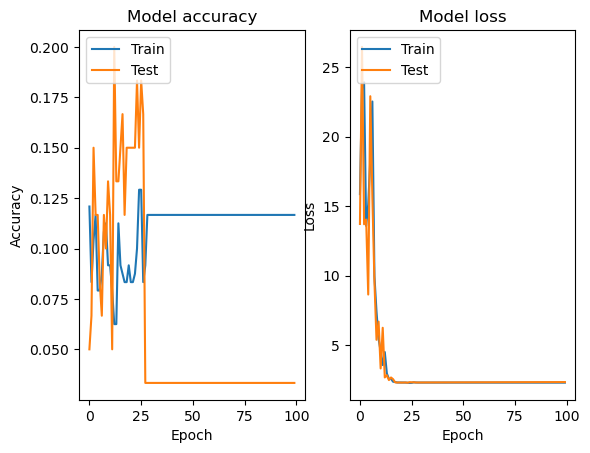

In [31]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [66]:
predictions = trashmodelo.predict(X_test)
predicted = np.argmax(predictions, axis=1)
forReal = np.argmax(y_test, axis=1)

print(f"Predicted:\t{predicted}")
print(f"For Real:\t{forReal}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79ec381b6de0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 407ms/step
Predicted:	[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
For Real:	[6 8 5 0 7 7 6 3 0 5 7 1 7 1 6 7 9 7 4 5 2 3 8 8 3 1 9 9 

In [18]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [19]:
_ = trashmodelo.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [20]:
real = np.argmax(y_test, axis=1).tolist()
predict = np.argmax(_, axis=1).tolist()

In [21]:
multilabel_confusion_matrix(real, predict)

array([[[53,  1],
        [ 1,  5]],

       [[54,  1],
        [ 1,  4]],

       [[53,  0],
        [ 1,  6]],

       [[50,  1],
        [ 2,  7]],

       [[55,  3],
        [ 0,  2]],

       [[54,  1],
        [ 0,  5]],

       [[55,  0],
        [ 0,  5]],

       [[48,  0],
        [ 2, 10]],

       [[57,  0],
        [ 3,  0]],

       [[51,  3],
        [ 0,  6]]])

In [22]:
accuracy_score(real, predict)

0.8333333333333334

In [42]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        image, results = mediapipe_detection(frame, holistic)
        draw_styled_landmarks(image, results)

        keypoints = extract_keypoints(results)
        if keypoints.size == 1662:
            keypoints = np.expand_dims(keypoints, axis=0)
            keypoints = np.repeat(keypoints, 30, axis=0)
            keypoints = keypoints.reshape(1, 30
            raise ValueError(f"Fuck it! , 1662, 1)
        else:Expected 1662 keypoints, but got {keypoints.size}")
        
        print(f"keypoints shape: {keypoints.shape}")
        
        predictions = trashmodelo.predict(keypoints)
        predicted_class = actions[np.argmax(predictions)]
        
        cv2.putText(image, f'Prediction: {predicted_class}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/radeonsi_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open zink: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/zink_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /usr/lib/dri/swrast_dri.so) (search paths /usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open radeonsi: /home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/zmq/backend/cython/../../../../.././libs

keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/bhavi/.conda/envs/G2Tenv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
QObject::moveToThread: Current thread (0x6f66ce0) is not the object's thread (0x7308ab0).
Cannot move to target thread (0x6f66ce0)

QObject::moveToThread: Current thread (0x6f66ce0) is not the object's thread (0x7308ab0).
Cannot move to target thread (0x6f66ce0)

QObject::moveToThread: Current thread (0x6f66ce0) is not the object's thread (0x7308ab0).
Cannot move to target thread (0x6f66ce0)

QObject::moveToThread: Current thread (0x6f66ce0) is not the object's thread (0x7308ab0).
Cannot move to target thread (0x6f66ce0)

QObject::moveToThread: Current thread (0x6f66ce0) is not the object's thread (0x7308ab0).
Cannot move to target thread (0x6f66ce0)

QObjec

keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
keypoints shape: (1, 30, 1662, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13